In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def phugoid_rhs(t, state, params):
    g, rho = params['g'], params['rho']
    C_D, C_L, wing_area = params['C_D'], params['C_L'], params['wing_area']
    m = params['m']
    T = params['T']

    V, theta, h, x = state  # Extract variables
    D = 0.5 * rho * C_D * wing_area * V**2  # Drag force
    L = 0.5 * rho * C_L * wing_area * V**2
    dVdt = -g * np.sin(theta) - D / m + T / m
    dthetadt = ((-g * np.cos(theta)) + L / m) / V
    dhdt = V * np.sin(theta)  # Altitude rate of change
    dxdt = V * np.cos(theta)

    return np.array([dVdt, dthetadt, dhdt, dxdt])

In [ ]:
def runge_kutta4(f, y0, t_values, params):

    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0
    dt = t_values[1] - t_values[0]

    for i in range(1, len(t_values)):
        t = t_values[i-1]
        y = y_values[i-1]
        k1 = dt * f(t, y, params)
        k2 = dt * f(t + dt/2, y + k1/2, params)
        k3 = dt * f(t + dt/2, y + k2/2, params)
        k4 = dt * f(t + dt, y + k3, params)
        y_values[i] = y + (k1 + 2*k2 + 2*k3 + k4) / 6

    return y_values

In [ ]:
# Specs for a Gulfstream G280
G280 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 1.225,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Initial conditions
v0 = 100.0   # Initial velocity (m/s)
theta0 = 0.05  # Initial pitch angle (rad)
h0 = 5000   # Initial altitude (m)
x0 = 0.0
y0 = np.array([v0, theta0, h0, x0])

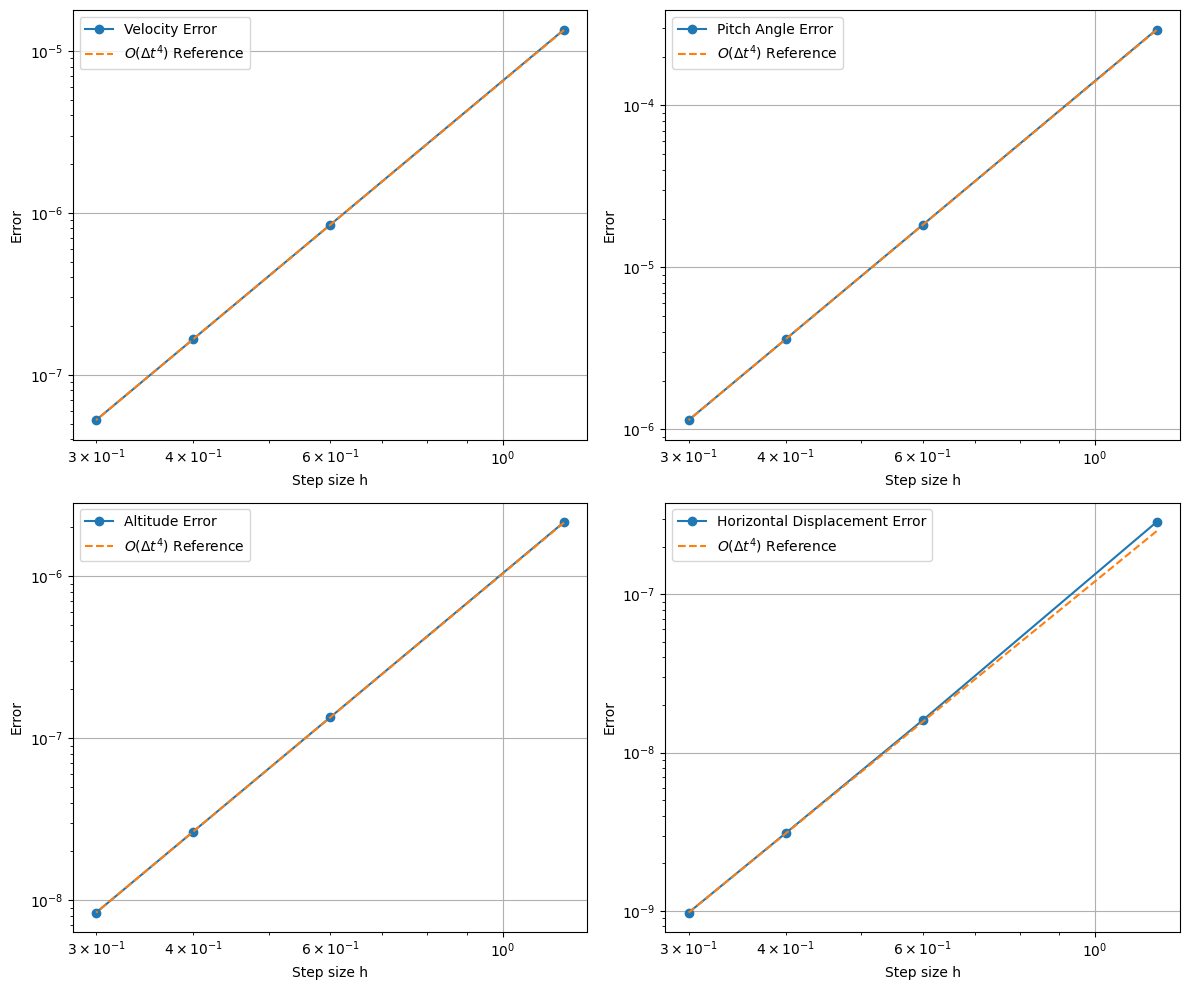

In [ ]:
from scipy.integrate import solve_ivp

# Use scipy's solve_ivp function to compute a psuedoanalytical solution
# We will use this solution to compare our approximation to in the error analysis below

# Compute the error plots for each solution in the first order system

t_final = 600  # Final time in seconds
N_values = [500, 1000, 1500, 2000]  # Number of time steps

errors_v = []
errors_theta = []
errors_h = []
errors_x = []

for n in N_values:
    t_values = np.linspace(0, t_final, n)
    y_numeric = runge_kutta4(phugoid_rhs, y0, t_values, G280)
    analytical_soln = solve_ivp(phugoid_rhs, [0, t_final], y0, args=(G280,), t_eval=t_values, method='DOP853', rtol=1e-10, atol=1e-12)

    y_analyt = analytical_soln['y'].T
    V_analyt = y_analyt[:, 0]
    theta_analyt = y_analyt[:, 1]
    h_analyt = y_analyt[:, 2] # Convert to [km]
    x_analyt = y_analyt[:, 3] # Convert to [km]

    # Extract solutions
    V_num = y_numeric[:, 0]
    theta_num = y_numeric[:, 1]
    h_num = y_numeric[:, 2]
    x_num = y_numeric[:, 3]

    # Compute error norms
    errors_v.append(np.linalg.norm(V_num - V_analyt) / np.linalg.norm(V_analyt))
    errors_theta.append(np.linalg.norm(theta_num - theta_analyt) / np.linalg.norm(theta_analyt))
    errors_h.append(np.linalg.norm(h_num - h_analyt) / np.linalg.norm(h_analyt))
    errors_x.append(np.linalg.norm(x_num - x_analyt) / np.linalg.norm(x_analyt))

# Compute step sizes
h_values = np.array([t_final / n for n in N_values])
c_v = errors_v[-1] / (h_values[-1]**4)
c_theta = errors_theta[-1] / (h_values[-1]**4)
c_h = errors_h[-1] / (h_values[-1]**4)
c_x = errors_x[-1] / (h_values[-1]**4)

# Reference O(h^4) line
h_ref = np.array(h_values)
error_ref_v = c_v * h_values**4
error_ref_theta = c_theta * h_values**4
error_ref_h = c_h * h_values**4
error_ref_x = c_x * h_values**4

# Plot errors
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].loglog(h_values, errors_v, 'o-', label='Velocity Error')
axs[0, 0].loglog(h_values, error_ref_v, '--', label=r'$O(\Delta t^4)$ Reference')
axs[0, 0].set_xlabel('Step size h')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].loglog(h_values, errors_theta, 'o-', label='Pitch Angle Error')
axs[0, 1].loglog(h_values, error_ref_theta, '--', label=r'$O(\Delta t^4)$ Reference')
axs[0, 1].set_xlabel('Step size h')
axs[0, 1].set_ylabel('Error')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].loglog(h_values, errors_h, 'o-', label='Altitude Error')
axs[1, 0].loglog(h_values, error_ref_h, '--', label=r'$O(\Delta t^4)$ Reference')
axs[1, 0].set_xlabel('Step size h')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].loglog(h_values, errors_x, 'o-', label='Horizontal Displacement Error')
axs[1, 1].loglog(h_values, error_ref_x, '--', label=r'$O(\Delta t^4)$ Reference')
axs[1, 1].set_xlabel('Step size h')
axs[1, 1].set_ylabel('Error')
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
plt.show()

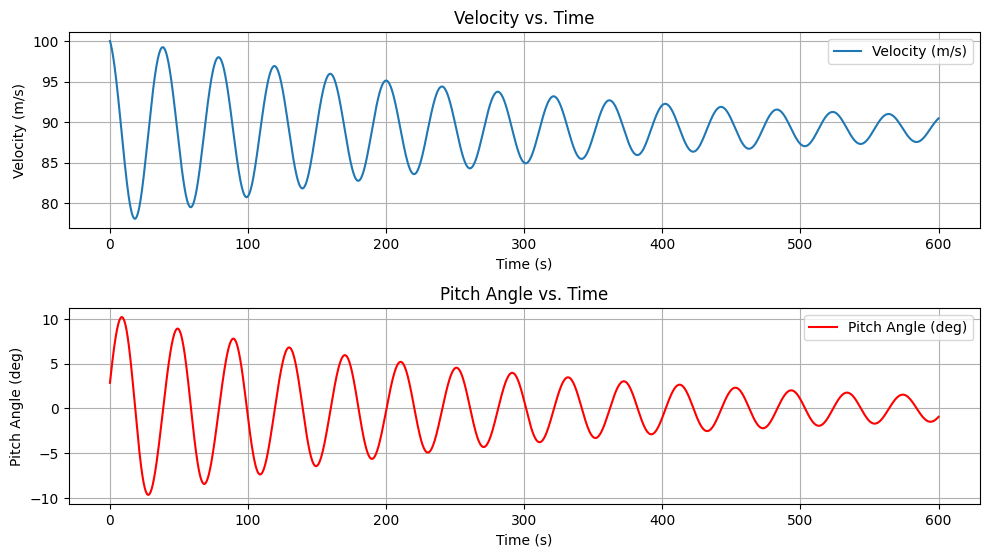

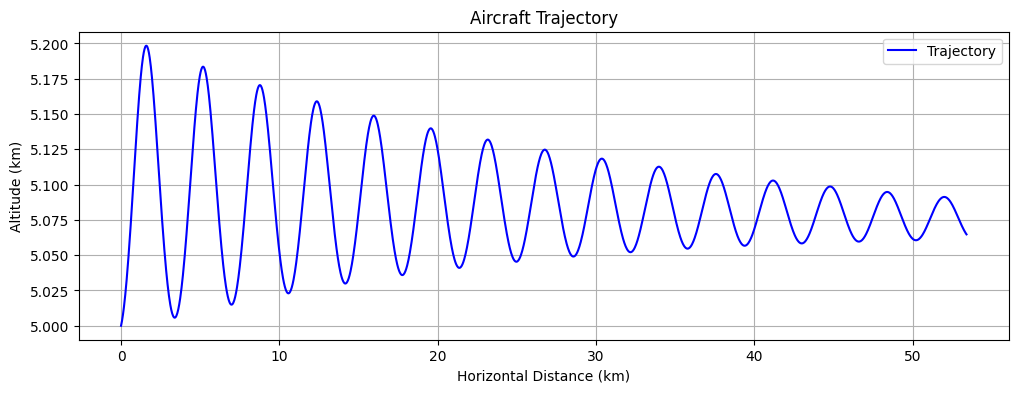

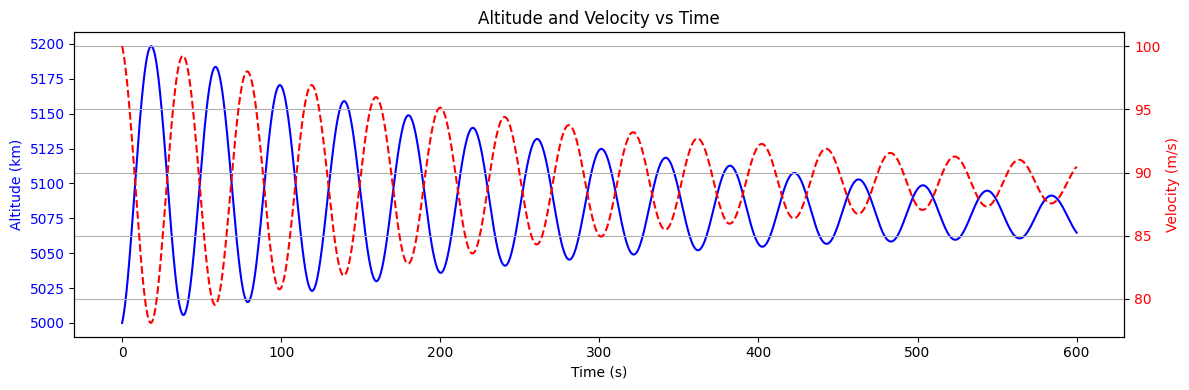

In [ ]:
# General phugoid behavior

t_final = 600
N_val = 2000 # Number of time steps
t_values = np.linspace(0, t_final, N_val)

soln = runge_kutta4(phugoid_rhs, y0, t_values, G280)

V_soln = soln[:, 0]
theta_soln = soln[:, 1]
h_soln = soln[:, 2] / 1000 # Convert to [km]
x_soln = soln[:, 3] / 1000 # Convert to [km]

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t_values, V_soln, label='Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_values, np.degrees(theta_soln), label='Pitch Angle (deg)', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')
plt.title('Pitch Angle vs. Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x_soln, h_soln, label='Trajectory', color='b')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('Aircraft Trajectory')
plt.legend()
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 4))

# Altitude on left y-axis
ax1.plot(t_values, h_analyt, 'b-', label='Altitude')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Altitude (km)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for velocity
ax2 = ax1.twinx()
ax2.plot(t_values, V_analyt, 'r--', label='Velocity')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Optional: Add title and grid
plt.title('Altitude and Velocity vs Time')
fig.tight_layout()
plt.grid()
plt.show()


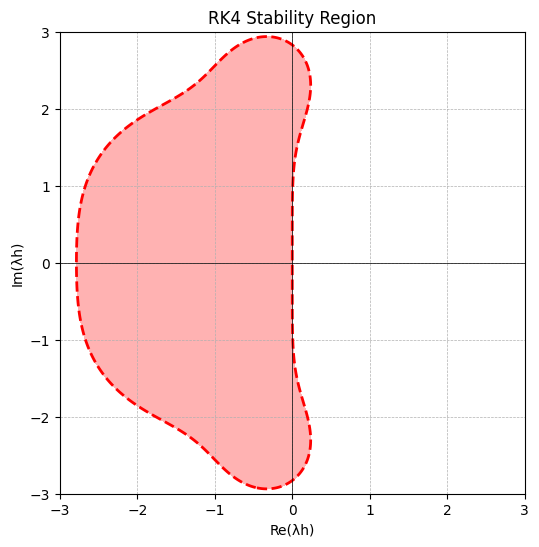

In [ ]:
# Generate data for RK4 stability plot using a grid
x_vals = np.linspace(-3, 3, 300)
y_vals = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y  # Complex grid

# Compute RK4 stability function R(z)
RZ = 1 + Z + (Z**2) / 2 + (Z**3) / 6 + (Z**4) / 24
stability_region = np.abs(RZ)

# Plot RK4 stability region
plt.figure(figsize=(6, 6))
plt.contourf(X, Y, stability_region, levels=[0, 1], colors=['red'], alpha=0.3)
plt.contour(X, Y, stability_region, levels=[1], colors=['r'], linewidths=2, linestyles="dashed")

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Re(λh)")
plt.ylabel("Im(λh)")
plt.title("RK4 Stability Region")
plt.grid(True, linestyle="--", linewidth=0.5)

# Show the plot
plt.show()

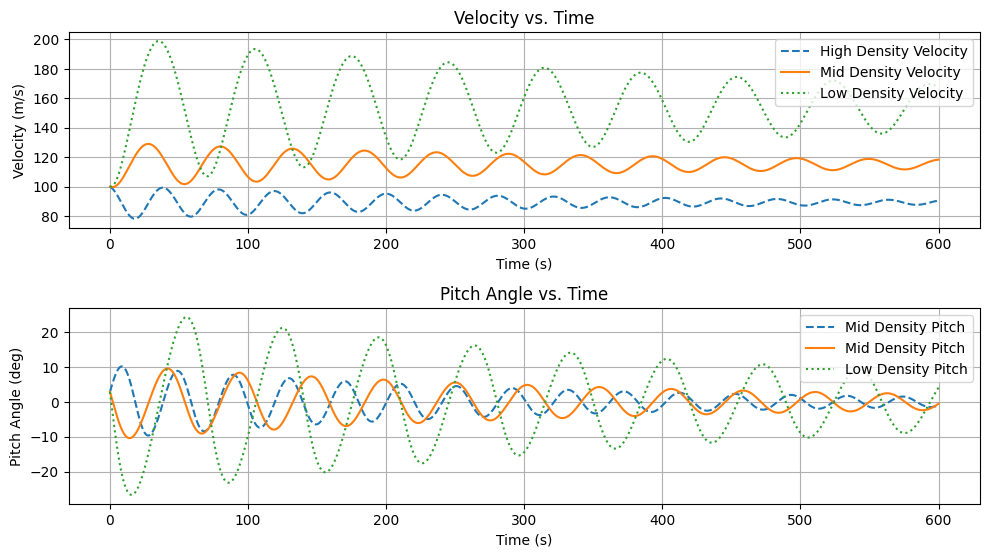

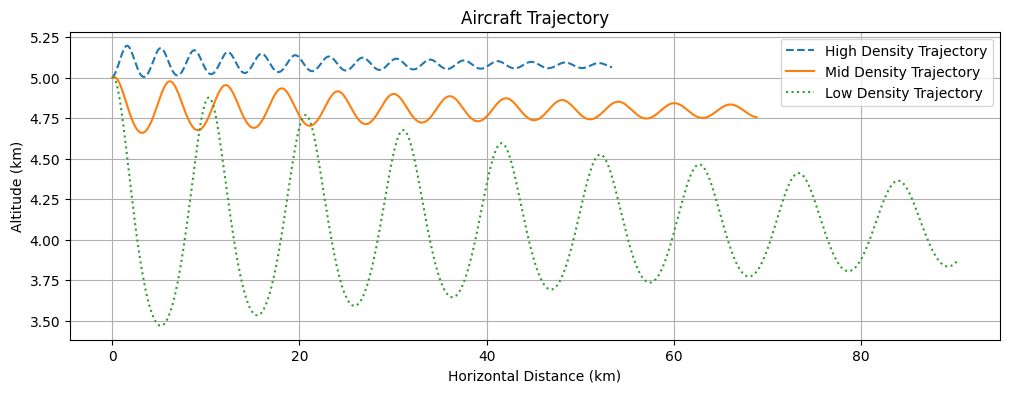

In [ ]:
# Answering question 1: What effect does varying the air density have on the phugoid system
# We will analize the Gulfstream G280 with varrying no parameters except for the air density

# Density conditions for close to sea level flight
G280_low = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 1.225,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Density conditions for roughly 15,000 ft ~ 5 km
G280_mid = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.7361,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Density conditions for roughly 32,000 ft ~ 10 km
G280_high = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,      # Air density (kg/m^3)
    'C_D': 0.03,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 34.6, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 5000          # Thrust (N)
}

# Initial conditions will remain the same for each simulation
# The altitude will also remain constant for better visualization of each trajectory

v0 = 100.0   # Initial velocity (m/s)
theta0 = 0.05  # Initial pitch angle (rad)
h0 = 5000   # Initial altitude (m)
x0 = 0.0
y0 = np.array([v0, theta0, h0, x0])

t_final = 600
N_val = 2000 # Number of time steps
t_values = np.linspace(0, t_final, N_val)

soln_low = runge_kutta4(phugoid_rhs, y0, t_values, G280_low)
soln_mid = runge_kutta4(phugoid_rhs, y0, t_values, G280_mid)
soln_high = runge_kutta4(phugoid_rhs, y0, t_values, G280_high)

V_low = soln_low[:, 0]
theta_low = soln_low[:, 1]
h_low = soln_low[:, 2] / 1000
x_low = soln_low[:, 3] / 1000

V_mid = soln_mid[:, 0]
theta_mid = soln_mid[:, 1]
h_mid = soln_mid[:, 2] / 1000
x_mid = soln_mid[:, 3] / 1000

V_high = soln_high[:, 0]
theta_high = soln_high[:, 1]
h_high = soln_high[:, 2] / 1000
x_high = soln_high[:, 3] / 1000

plt.figure(figsize=(10, 8))

# Velocity plot
plt.subplot(3, 1, 1)
plt.plot(t_values, V_low, label='High Density Velocity', linestyle='dashed')
plt.plot(t_values, V_mid, label='Mid Density Velocity', linestyle='solid')
plt.plot(t_values, V_high, label='Low Density Velocity', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.grid()
plt.legend()

# Pitch angle plot
plt.subplot(3, 1, 2)
plt.plot(t_values, np.degrees(theta_low), label='Mid Density Pitch', linestyle='dashed')
plt.plot(t_values, np.degrees(theta_mid), label='Mid Density Pitch', linestyle='solid')
plt.plot(t_values, np.degrees(theta_high), label='Low Density Pitch', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')
plt.title('Pitch Angle vs. Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(12, 4))
plt.plot(x_low, h_low, label='High Density Trajectory', linestyle='dashed')
plt.plot(x_mid, h_mid, label='Mid Density Trajectory', linestyle='solid')
plt.plot(x_high, h_high, label='Low Density Trajectory', linestyle='dotted')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('Aircraft Trajectory')
plt.legend()
plt.grid()
plt.show()

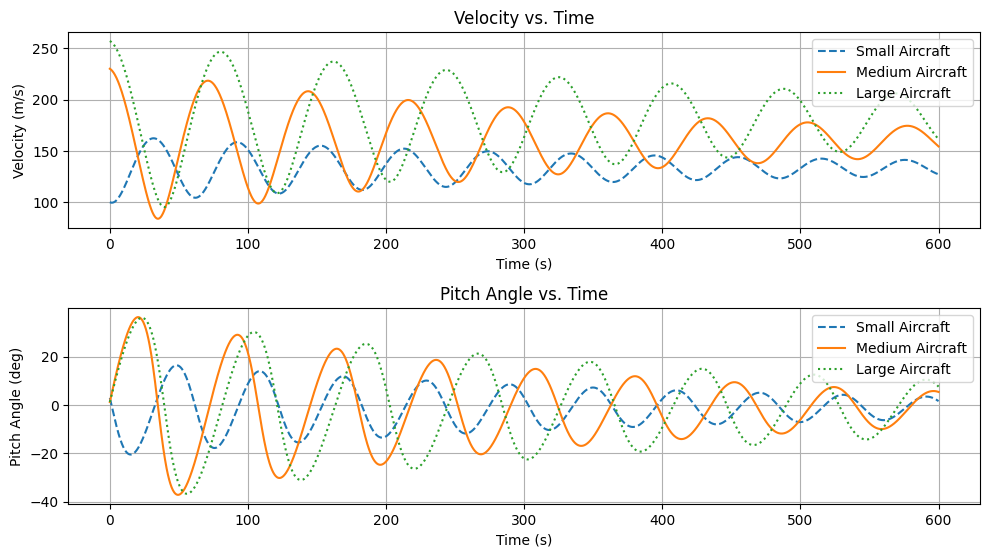

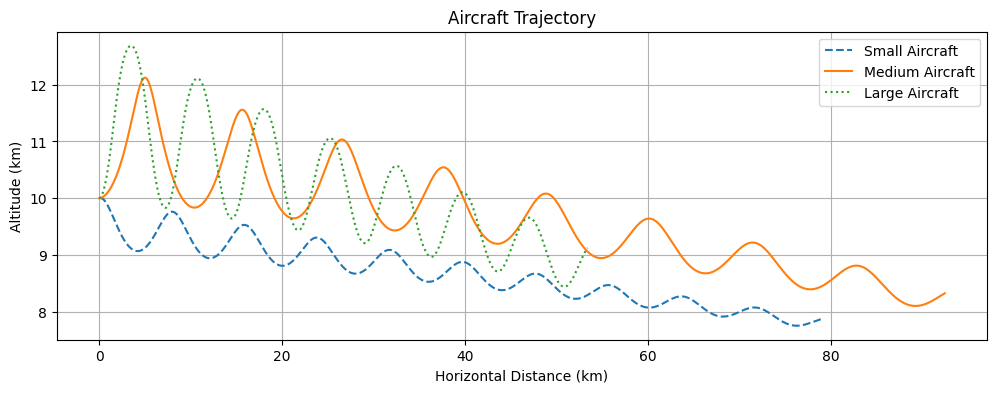

In [ ]:
# Parameters for a small aircraft
G280 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,      # Air density (kg/m^3)
    'C_D': 0.022,       # Drag coefficient
    'C_L': 1.0,        # Lift coefficient
    'wing_area': 46, # Wing area (m^2)
    'm': 17200,        # Mass (kg)
    'T': 0          # Thrust (N)
}

# Initial conditions for a G280
y0_g280 = np.array([100.00, 0.05, 10000, 0.0])

# Parameters for a mid size aircraft
embraerE2 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,     # Air density at ~32,000 ft (kg/m^3)
    'C_D': 0.03,       # Estimated drag coefficient
    'C_L': 1.0,        # Estimated lift coefficient
    'wing_area': 103, # Wing area (m^2)
    'm': 55000,        # Estimated in-flight mass (kg)
    'T': 0         # Estimated thrust (N)
}

y0_E2 = np.array([230.0, 0.02, 10000, 0.0])

# Parameters for a large aircraft
boeing787 = {
    'g': 9.81,         # Gravity (m/s^2)
    'rho': 0.4127,     # Air density at ~32,000 ft (kg/m^3)
    'C_D': 0.024,       # Estimated drag coefficient
    'C_L': 1.0,        # Estimated lift coefficient
    'wing_area': 325,  # Wing area (m^2)
    'm': 220000,       # Estimated in-flight mass (kg)
    'T': 0         # Estimated thrust (N)
}

y0_787 = np.array([257.0, 0.02, 10000, 0.0])

t_final = 600
N_val = 2000 # Number of time steps
t_values = np.linspace(0, t_final, N_val)

soln_g280 = runge_kutta4(phugoid_rhs, y0_g280, t_values, G280)
soln_E2 = runge_kutta4(phugoid_rhs, y0_E2, t_values,embraerE2)
soln_787 = runge_kutta4(phugoid_rhs, y0_787, t_values,boeing787)

V_g280 = soln_g280[:, 0]
theta_g280 = soln_g280[:, 1]
h_g280 = soln_g280[:, 2] / 1000
x_g280 = soln_g280[:, 3] / 1000

V_E2 = soln_E2[:, 0]
theta_E2 = soln_E2[:, 1]
h_E2 = soln_E2[:, 2] / 1000
x_E2 = soln_E2[:, 3] / 1000

V_787 = soln_787[:, 0]
theta_787 = soln_787[:, 1]
h_787 = soln_787[:, 2] / 1000
x_787 = soln[:, 3] / 1000

plt.figure(figsize=(10, 8))

# Velocity plot
plt.subplot(3, 1, 1)
plt.plot(t_values, V_g280, label='Small Aircraft', linestyle='dashed')
plt.plot(t_values, V_E2, label='Medium Aircraft', linestyle='solid')
plt.plot(t_values, V_787, label='Large Aircraft', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.grid()
plt.legend()

# Pitch angle plot
plt.subplot(3, 1, 2)
plt.plot(t_values, np.degrees(theta_g280), label='Small Aircraft', linestyle='dashed')
plt.plot(t_values, np.degrees(theta_E2), label='Medium Aircraft', linestyle='solid')
plt.plot(t_values, np.degrees(theta_787), label='Large Aircraft', linestyle='dotted')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (deg)')
plt.title('Pitch Angle vs. Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(12, 4))
plt.plot(x_g280, h_g280, label='Small Aircraft', linestyle='dashed')
plt.plot(x_E2, h_E2, label='Medium Aircraft', linestyle='solid')
plt.plot(x_787, h_787, label='Large Aircraft', linestyle='dotted')
plt.xlabel('Horizontal Distance (km)')
plt.ylabel('Altitude (km)')
plt.title('Aircraft Trajectory')
plt.legend()
plt.grid()
plt.show()